# **Preprocessing**

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open 
import glob 
import os

import unicodedata
import string

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

In [ ]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                    if unicodedata.category(c) != 'Mn' and c in all_letters)

print(unicode_to_ascii("Ślusàrski"))

Slusarski


In [ ]:
print(glob.glob('../data/*.txt'))

['../data/Scottish.txt', '../data/Dutch.txt', '../data/Portuguese.txt', '../data/Japanese.txt', '../data/Arabic.txt', '../data/French.txt', '../data/Russian.txt', '../data/Chinese.txt', '../data/English.txt', '../data/Polish.txt', '../data/Vietnamese.txt', '../data/Italian.txt', '../data/Greek.txt', '../data/Korean.txt', '../data/German.txt', '../data/Czech.txt', '../data/Irish.txt', '../data/Spanish.txt']


In [ ]:
category_lines = {}
all_categories = []

def process_data(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicode_to_ascii(line) for line in lines]

for filename in glob.glob('../data/*.txt'):
  language = filename.split('/')[-1][:-4]
  all_categories.append(language)
  category_lines[language] = process_data(filename)

In [ ]:
n_categories = len(all_categories)

# **TENSORS**

In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
def letter_to_index(letter):
  return all_letters.find(letter)

def letter_to_tensor(letter):
  one_hot = torch.zeros(1, n_letters)
  one_hot[0][letter_to_index(letter)] = 1
  return one_hot

print(letter_to_tensor('o'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])


In [ ]:
def line_to_tensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for ind, letter in enumerate(line):
    tensor[ind] = letter_to_tensor(letter)
  return tensor

print(line_to_tensor('hi').shape)

torch.Size([2, 1, 56])


## MODEL

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)

    self.softmax = nn.LogSoftmax(1)

  def forward(self, input, hidden):
    emb = torch.cat((input, hidden), 1)
    hidden_state = self.i2h(emb)
    output = self.i2o(emb)
    output = self.softmax(output)

    return output, hidden_state
  
  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = letter_to_tensor('A')
hidden = torch.zeros(1, n_hidden)

output, _ = rnn.forward(input, hidden)

In [ ]:
def category_from_output(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()

  return all_categories[category_i], category_i

print(category_from_output(output))

('Korean', 13)


In [ ]:
import random

def random_choice(l):
  return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
  category = random_choice(all_categories)
  line = random_choice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = line_to_tensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category =', category, '/ line =', line)
  print(category_tensor, line_tensor)


In [ ]:
criterion = nn.NLLLoss()

learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.init_hidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn.forward(line_tensor[i], hidden)
  print(output)
  print(category_tensor)
  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)
  
  return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess, guess_i = category_from_output(output)
    print(iter, iter/n_iters, loss, line, guess, category)
  
  if iter % plot_every == 0:
    all_losses.append(current_loss/plot_every)
    current_loss = 0


5000 0.05 2.6378629207611084 Allport Italian English
10000 0.1 0.8043183088302612 Takemago Japanese Japanese
15000 0.15 2.0767393112182617 Cuoco Vietnamese Italian
20000 0.2 1.3179370164871216 Alvarez Portuguese Spanish
25000 0.25 1.832685112953186 Reveley Spanish English
30000 0.3 3.1335160732269287 Rompaij French Dutch
35000 0.35 2.0781612396240234 Kalogeria Czech Greek
40000 0.4 0.7100926637649536 Lai Chinese Chinese
45000 0.45 0.48469802737236023 Shiratori Japanese Japanese
50000 0.5 4.954097747802734 Gerges English Arabic
55000 0.55 1.6322245597839355 Craig Scottish Scottish
60000 0.6 0.7524165511131287 Sneiders Dutch Dutch
65000 0.65 1.1575745344161987 Henriques Portuguese Portuguese
70000 0.7 1.2642368078231812 Deforest German French
75000 0.75 0.8528753519058228 Crespo Portuguese Portuguese
80000 0.8 1.559869647026062 Dubicki Japanese Polish
85000 0.85 0.23345427215099335 Suk Korean Korean
90000 0.9 0.0068380157463252544 Vassilopulos Greek Greek
95000 0.95 2.2769687175750732 Br

In [ ]:
category, line, category_tensor, line_tensor = randomTrainingExample()
output, loss = train(category_tensor, line_tensor)

tensor([[-9.3171e+00, -8.0231e+00, -1.0833e+01, -6.1478e+00, -7.7561e+00,
         -8.7408e+00, -1.4790e-02, -1.6232e+01, -6.0836e+00, -6.9409e+00,
         -1.9677e+01, -9.1900e+00, -5.7975e+00, -1.7983e+01, -7.5351e+00,
         -5.4650e+00, -8.9708e+00, -8.3375e+00]], grad_fn=<LogSoftmaxBackward>)
tensor([6])


In [ ]:
loss = criterion(output, category_tensor)
print(loss.item())

0.014790172688663006


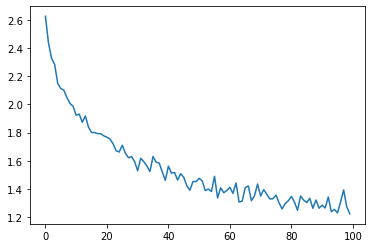

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
confusion = torch.zeros(n_categories, n_categories)

n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.init_hidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn.forward(line_tensor[i], hidden)

  return output

for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = category_from_output(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()




In [ ]:
print(confusion)

tensor([[0.6109, 0.0432, 0.0000, 0.0188, 0.0075, 0.0357, 0.0038, 0.0376, 0.1053,
         0.0000, 0.0113, 0.0038, 0.0094, 0.0000, 0.0827, 0.0000, 0.0301, 0.0000],
        [0.0018, 0.5267, 0.0107, 0.0302, 0.0302, 0.0516, 0.0285, 0.0249, 0.0285,
         0.0142, 0.0267, 0.0036, 0.0214, 0.0214, 0.1068, 0.0463, 0.0160, 0.0107],
        [0.0123, 0.0333, 0.5070, 0.0509, 0.0228, 0.0193, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0596, 0.0544, 0.0000, 0.0211, 0.1158, 0.0246, 0.0789],
        [0.0057, 0.0000, 0.0057, 0.8582, 0.0416, 0.0000, 0.0057, 0.0132, 0.0000,
         0.0038, 0.0038, 0.0378, 0.0019, 0.0095, 0.0000, 0.0057, 0.0038, 0.0038],
        [0.0000, 0.0074, 0.0000, 0.0773, 0.7459, 0.0000, 0.0000, 0.0092, 0.0147,
         0.0147, 0.0000, 0.0000, 0.0589, 0.0018, 0.0442, 0.0018, 0.0239, 0.0000],
        [0.0381, 0.0690, 0.0073, 0.0091, 0.0490, 0.4664, 0.0181, 0.0018, 0.1089,
         0.0054, 0.0054, 0.0181, 0.0236, 0.0127, 0.1034, 0.0236, 0.0399, 0.0000],
        [0.0278, 0.020

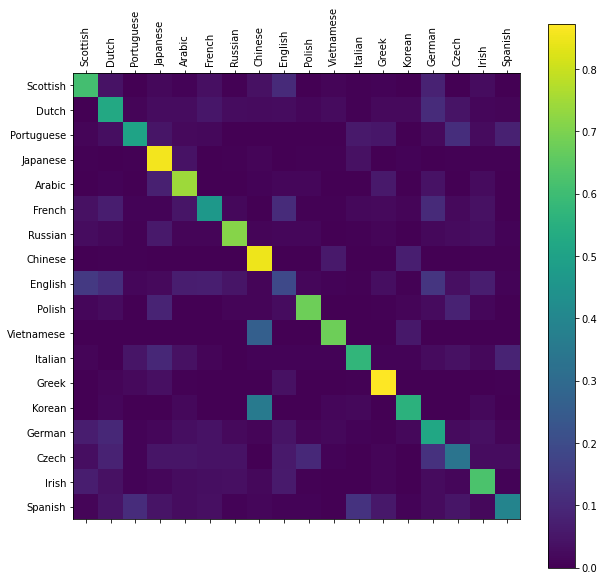

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()